# Deep Dive into DeepVariant

This note shows how DeepVariant generates labels for training a deep neural network to make better variant call from next generation sequencing data.

## Boilerplate Code

We inject an environment from DeepVariant(DV) "com_google_deepvariant" from a build so we can use the `variants_pb2` class. It allows us to explore a bit how DV labels training set from the GIAB variant golden call set and an alignment BAM file of a set of reads.


In [1]:
import sys
sys.path.insert(0, "/home/dnanexus/dv-setup/com_google_deepvariant/")
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from third_party.nucleus.protos import variants_pb2
from tensorflow.core.example import example_pb2
from deepvariant.protos import deepvariant_pb2
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Helper Functions
Define some helper funtions so we can see the data inside Google Protocal Buffer data structure.

Reference:  https://github.com/google/deepvariant/blob/c2167e7c90f016905f309f118eb3897935ee7c5f/docs/visualizing_examples.ipynb


In [3]:

def get_bytes_list(example, key):
    """Returns the bytes-list corresponding to a key in a tf.Example."""
    return example.features.feature[key].bytes_list.value

def read_example(path, max_records=None):
    """Yields the parsed records in tfrecord formatted file path.

    Args:
        path: String. A path to a tfrecord formatted file containing tensorflow.Example.
        max_records: int >= 0 or None. Maximum number of records to read from path.
          If None, the default, all records will be read.

    Yields:
        tensorflow.Example on each record in path in order.
    """
    proto = example_pb2.Example
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    i = 0
    for buf in tf.python_io.tf_record_iterator(path, options):
        i += 1
        if max_records is not None and i > max_records:
            return
        yield proto.FromString(buf)
        
def read_call_variant_out(path, max_records=None):
    proto = deepvariant_pb2.CallVariantsOutput
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    i = 0
    for buf in tf.python_io.tf_record_iterator(path, options):
        i += 1
        if max_records is not None and i > max_records:
            return
        yield proto.FromString(buf)

def get_bytes_list(example, key):
    """Returns the bytes-list corresponding to a key in a tf.Example."""
    return example.features.feature[key].bytes_list.value

def get_int64_list(example, key):
    """Returns the int64-list corresponding to a key in a tf.Example."""
    return example.features.feature[key].int64_list.value

def get_label(example):
    """Returns the label(class) of the example. Expected values are 0 (HOM-REF), 1(HET), 2(HOM-ALT)"""
    return get_int64_list(example, 'label')[0]

def get_alt_allele_indices(example):
    byte_list = get_bytes_list(example, "alt_allele_indices/encoded")
    return [ord(b) for b in byte_list[0][2:]]


def imshows(images, labels=None, n=None, scale=10, axis='off', **kwargs):
    """Plots a list of images in a row.

    Args:
        images: List of image arrays.
        labels: List of str or None. Image titles.
        n: int or None. How many images in the list to display. If this is None,
          display all of them.
        scale: int. How big each image is.
        axis: str. How to plot each image.
        **kwargs: Keyword arguments for Axes.imshow.
    Returns:
        None.
    """
    n = len(images) if (n is None) else n
    with sns.axes_style('white'):
        _, axs = plt.subplots(1, n, figsize=(n * scale, scale))
        for i in xrange(n):
            axs[i].imshow(images[i], **kwargs)
            axs[i].axis(axis)
            if labels:
                axs[i].set_title(labels[i])
        plt.show()

def visualize_example(example):
    # Read in the image bytestring and its shape: [100, 221, 6].
    image = get_bytes_list(example, 'image/encoded')[0]
    shape = (100, 221, 6)
    # Parse the bytestring and reshape to an image.
    image = np.frombuffer(image, np.uint8).reshape(shape)
    # Split the tensor by its channels dimension and plot.
    channels = [image[:, :, i] for i in range(shape[-1])]
    # Prepend an image: RGBA image reconstructed from the 6-channels
    channels.insert(0, channels_to_rgb(channels))
    titles = ["reconstructed RGBA (label=%s)" % get_label(example),
              "read base", "base quality", "mapping quality", "strand",
              "supports variant", "supports reference"]
    imshows(channels, titles, axis="image", scale=5, vmin=0, vmax=256, cmap="hot")

def visualize_support(example):
    # Read in the image bytestring and its shape: [100, 221, 6].
    image = get_bytes_list(example, 'image/encoded')[0]
    shape = (100, 221, 6)
    # Parse the bytestring and reshape to an image.
    image = np.frombuffer(image, np.uint8).reshape(shape)

    channels = [image[:, :, i] for i in (4,5)]
    variant = variants_pb2.Variant.FromString(get_bytes_list(example, 'variant/encoded')[0])
    titles = ["supports variant (label={}, {})".format(str(get_label(example)), 
                                                      str([variant.alternate_bases[c].encode("utf-8") for c in get_alt_allele_indices(example)])), 
              "supports reference"]
    imshows(channels, titles, axis="image", scale=5, vmin=0, vmax=256, cmap="hot")
    
def channels_to_rgb(channels):
    # Reconstruct the original channels
    base = channels[0]
    qual = np.minimum(channels[1], channels[2])
    strand = channels[3]
    alpha = np.multiply(
        channels[4] / 254.0,
        channels[5] / 254.0)
    return np.multiply(
        np.stack([base, qual, strand]),
        alpha).astype(np.uint8).transpose([1, 2, 0])


Copy data to a DNAnexus user director so we can mount with a DeepVariant docker container.

In [4]:
%%bash
mkdir -p /home/dnanexus/dv-run
cd data
cp HG002.15kb.Q20.hs37d5.pbmm2.MAPQ60_chr20.bam HG002.15kb.Q20.hs37d5.pbmm2.MAPQ60_chr20.bam.bai /home/dnanexus/dv-run
cp HG002_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz /home/dnanexus/dv-run
cp HG002_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz.tbi /home/dnanexus/dv-run
cp HG002_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-22_v.3.3.2_highconf_noinconsistent_chr20.bed /home/dnanexus/dv-run
cp -a DeepVariant-inception_v3-0.7.2+data-wgs_standard/ /home/dnanexus/dv-run
cp hs37d5.fa hs37d5.fa.fai /home/dnanexus/dv-run


## How Does DeepVariant Label a Candidate with Multi Alternative Alleles 

Run `make_examples` to label variants. 
We use

```
--vsc_min_fraction_snps 0.05 \
--vsc_min_fraction_indels 0.05,
```
so we can examine how DeepVariant handles multi alternative alleles case.

In [5]:
%%bash
docker run \
    -v /home/dnanexus/dv-run:/dv-run \
    gcr.io/deepvariant-docker/deepvariant:0.7.2 \
    /opt/deepvariant/bin/make_examples \
        --mode training \
        --norealign_reads \
        --vsc_min_fraction_snps 0.05 \
        --vsc_min_fraction_indels 0.05 \
        --ref /dv-run/hs37d5.fa \
        --truth_variants /dv-run/HG002_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz \
        --confident_regions /dv-run/HG002_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-22_v.3.3.2_highconf_noinconsistent_chr20.bed \
        --reads /dv-run/HG002.15kb.Q20.hs37d5.pbmm2.MAPQ60_chr20.bam \
        --examples "/dv-run/examples-training.tfrecord.gz" \
        --regions "20:1331920-1331960" \
        --sample_name "sample_name" 

I0207 22:32:29.075154 140147751589632 make_examples.py:1080] Preparing inputs
2019-02-07 22:32:29.076790: W third_party/nucleus/io/sam_reader.cc:128] Unknown tag pb: in header line, ignoring: @HD	VN:1.5	SO:coordinate	pb:3.0.1
2019-02-07 22:32:29.076976: W third_party/nucleus/io/sam_reader.cc:525] Unrecognized SAM header type, ignoring: 
I0207 22:32:29.077318 140147751589632 genomics_reader.py:213] Reading /dv-run/HG002.15kb.Q20.hs37d5.pbmm2.MAPQ60_chr20.bam with NativeSamReader
I0207 22:32:29.153141 140147751589632 genomics_reader.py:213] Reading /dv-run/HG002_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz with NativeVcfReader
I0207 22:32:29.167977 140147751589632 make_examples.py:996] Common contigs are [u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21', u'22', u'X', u'Y']
I0207 22:32:29.176605 140147751589632 make_examples.py:1086] Writing example

Print out the labelled example. In this case, there are three examples generated for one candidate location.

In [6]:
src = '/home/dnanexus/dv-run/examples-training.tfrecord.gz'
examples = list(read_example(src, 100))
for i,e in enumerate(examples[1:]):
    
    print("Example {}:".format(i))
    
    variant = variants_pb2.Variant.FromString(get_bytes_list(e, 'variant/encoded')[0])
    print("\tlocus:", get_bytes_list(e, "locus")[0]) 
    print("\treference base(s): {}".format(variant.reference_bases))
    print("\talternative base(s): {}".format([c.encode("utf-8")  for c in variant.alternate_bases]))
    print("\talt allele(s):", [variant.alternate_bases[c].encode("utf-8") for c in get_alt_allele_indices(e)]) 
    print("\tlabel:", get_label(e))
    
    print()

Example 0:
	locus: 20:1331941-1331941
	reference base(s): A
	alternative base(s): ['G', 'T']
	alt allele(s): ['G']
	label: 1

Example 1:
	locus: 20:1331941-1331941
	reference base(s): A
	alternative base(s): ['G', 'T']
	alt allele(s): ['T']
	label: 0

Example 2:
	locus: 20:1331941-1331941
	reference base(s): A
	alternative base(s): ['G', 'T']
	alt allele(s): ['G', 'T']
	label: 1



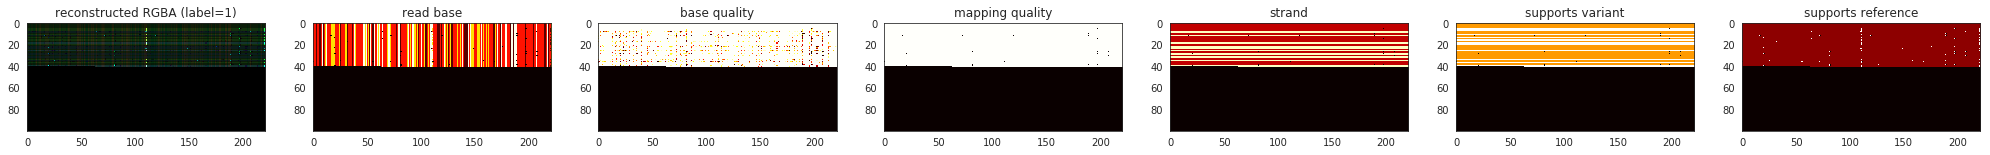

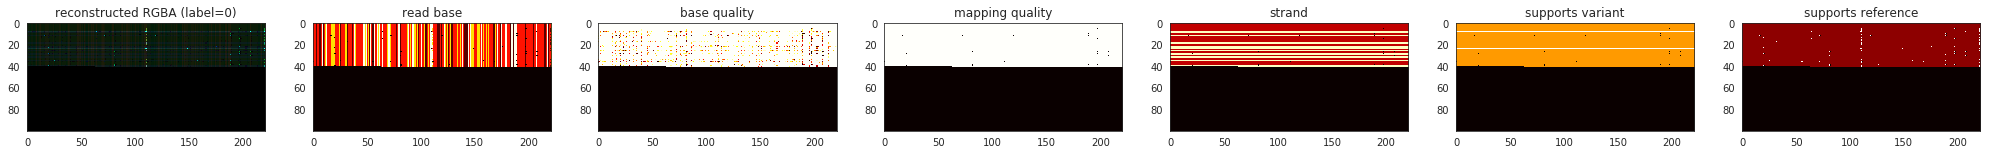

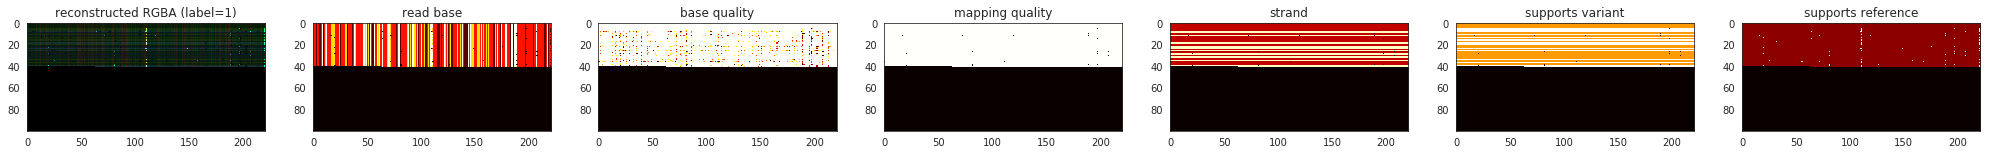

In [7]:
# After you run this cell, images should show up.
for example in examples[1:]:
    visualize_example(example)

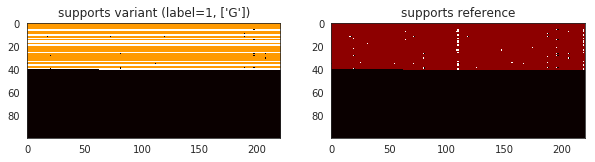

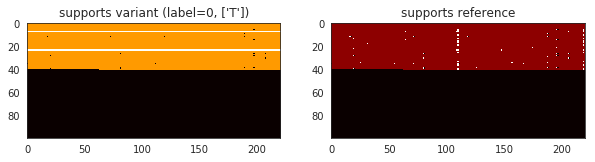

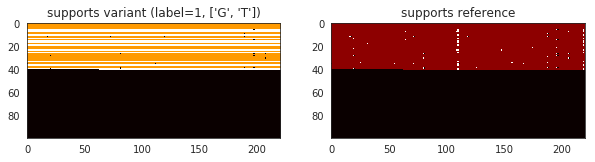

In [8]:
# After you run this cell, images should show up.
for example in examples[1:]:
    visualize_support(example)

## How Does DeepVariant Make a Call For A Candidate With Multi Alternative Alleles 

Running the `make_examples` in the "calling" mode.

In [9]:
%%bash

docker run \
    -v /home/dnanexus/dv-run:/dv-run \
    gcr.io/deepvariant-docker/deepvariant:0.7.2 \
    /opt/deepvariant/bin/make_examples \
        --mode calling \
        --norealign_reads \
        --ref "/dv-run/hs37d5.fa" \
        --vsc_min_fraction_snps 0.05 \
        --vsc_min_fraction_indels 0.05 \
        --reads "/dv-run/HG002.15kb.Q20.hs37d5.pbmm2.MAPQ60_chr20.bam" \
        --examples "/dv-run/examples-calling.tfrecord.gz" \
        --regions "20:1331920-1331960" \
        --sample_name "sample_name" 

I0207 22:32:35.814466 140234770155264 make_examples.py:1080] Preparing inputs
2019-02-07 22:32:35.816003: W third_party/nucleus/io/sam_reader.cc:128] Unknown tag pb: in header line, ignoring: @HD	VN:1.5	SO:coordinate	pb:3.0.1
2019-02-07 22:32:35.816157: W third_party/nucleus/io/sam_reader.cc:525] Unrecognized SAM header type, ignoring: 
I0207 22:32:35.816473 140234770155264 genomics_reader.py:213] Reading /dv-run/HG002.15kb.Q20.hs37d5.pbmm2.MAPQ60_chr20.bam with NativeSamReader
I0207 22:32:35.826663 140234770155264 make_examples.py:996] Common contigs are [u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21', u'22', u'X', u'Y']
I0207 22:32:35.835225 140234770155264 make_examples.py:1086] Writing examples to /dv-run/examples-calling.tfrecord.gz
2019-02-07 22:32:35.836293: I third_party/nucleus/io/sam_reader.cc:561] Setting HTS_OPT_BLOCK_SIZE to 134217728
2019-02-07 22:32:36.008637: W third_party/nucleus/

Running `call_variants` and `postprocess_variants` to see how DeepVariant handles the multi alternative allele case.

In [10]:
%%bash

docker run \
  -v /home/dnanexus/dv-run:/dv-run \
  gcr.io/deepvariant-docker/deepvariant:0.7.2  \
  /opt/deepvariant/bin/call_variants \
     --outfile "/dv-run/call_variants_output.tfrecord.gz" \
     --examples "/dv-run/examples-calling.tfrecord.gz" \
     --checkpoint "/dv-run/DeepVariant-inception_v3-0.7.2+data-wgs_standard/model.ckpt" \
     --execution_hardware cpu
        
        
docker run \
  -v /home/dnanexus/dv-run:/dv-run \
  gcr.io/deepvariant-docker/deepvariant:0.7.2 \
  /opt/deepvariant/bin/postprocess_variants \
  --ref "/dv-run/hs37d5.fa" \
  --infile "/dv-run/call_variants_output.tfrecord.gz" \
  --outfile "/dv-run/call_variants_output.vcf"

I0207 22:32:40.870594 140341751482112 call_variants.py:292] Set KMP_BLOCKTIME to 0
2019-02-07 22:32:40.955711: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2 FMA
2019-02-07 22:32:40.961377: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
I0207 22:32:40.992373 140341751482112 modeling.py:357] Initializing model with random parameters
W0207 22:32:40.994369 140341751482112 tf_logging.py:125] Using temporary folder as model directory: /tmp/tmprD0soY
I0207 22:32:40.994637 140341751482112 tf_logging.py:115] Using config: {'_save_checkpoints_secs': 1000, '_num_ps_replicas': 0, '_keep_checkpoint_max': 100000, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa39384dd90>, 

Print out the output from `call_variants` where the `genotype_probabilities` is drived from the IceptionNet v3 with the trained network parameters.

In [11]:
src = '/home/dnanexus/dv-run/call_variants_output.tfrecord.gz'
cvo = list(read_call_variant_out(src, 100))

In [12]:
for i, _cvo in enumerate(cvo[1:]):
    
    v = _cvo.variant
    print("Example {} Call Variant Output:".format(i))
    
    print("\tlocus: {}:{}-{}".format(v.reference_name, v.start ,v.end)) 
    print("\treference base(s): {}".format(variant.reference_bases))
    print("\talternative bases: {}".format([c.encode("utf-8") for c in v.alternate_bases]))
    print("\talt allele(s):", [v.alternate_bases[c].encode("utf-8") for c in _cvo.alt_allele_indices.indices]) 
    print("\tgenotype probabilities:", _cvo.genotype_probabilities)
    
    print()

Example 0 Call Variant Output:
	locus: 20:1331940-1331941
	reference base(s): A
	alternative bases: ['G', 'T']
	alt allele(s): ['G']
	genotype probabilities: [0.0002641702, 0.9997351766, 6.532e-07]

Example 1 Call Variant Output:
	locus: 20:1331940-1331941
	reference base(s): A
	alternative bases: ['G', 'T']
	alt allele(s): ['T']
	genotype probabilities: [0.9992206097, 0.0007750907, 4.2996e-06]

Example 2 Call Variant Output:
	locus: 20:1331940-1331941
	reference base(s): A
	alternative bases: ['G', 'T']
	alt allele(s): ['G', 'T']
	genotype probabilities: [0.0001638031, 0.9998347759, 1.421e-06]



In [13]:
!cat /home/dnanexus/dv-run/call_variants_output.vcf | grep -v "#"

20	1331940	.	A	AG	0	RefCall	.	GT:GQ:DP:AD:VAF:PL	0/0:25:36:34,2:0.0555556:0,24,48
20	1331941	.	A	G	35.8	PASS	.	GT:GQ:DP:AD:VAF:PL	0/1:36:36:20,13:0.361111:35,0,61


In this case Allele `T` is removed becuase example 1. The example 2 alt. alleles  `['G', 'T']` is overlapped with `T` so it is also get removed.  See `merge_predictions()`, `get_alt_alleles_to_remove()` and  `convert_call_variants_outputs_to_probs_dict()` in the `deepvariant/postprocess_variants.py`.

--Jason Chin, Feb. 3. 2019